# Use Python <3.10

This package heavily utilizes the pyMuellerMat package that makes Mueller matrices from "system dictionaries" detailing the instrument configuration. Make sure to clone the physical_models branch of pyMuellerMat at https://github.com/maxwellmb/pyMuellerMat/.

In [1]:
import sys
import numpy as np
from pathlib import Path
from vampires_calibration.instruments import fit_CHARIS_Mueller_matrix_by_bin_pickoff
from vampires_calibration.csv_tools import write_fits_info_to_csv,read_csv,read_csv_physical_model_all_bins
from vampires_calibration.fitting import *
from vampires_calibration.utils import *
from vampires_calibration.plotting import plot_data_and_model
from pyMuellerMat.physical_models.charis_physical_models import *
from matplotlib.ticker import MultipleLocator
import matplotlib as plt
# Plot settings that I like
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 16,
    "lines.linewidth": 3,
})

# Step 1: Write FITS Info to CSV

In [9]:
# Get paths to both processed and raw data 
# Make sure these directories have cubes with corresonding numbers
cube_dir = '/Users/thomasmcintosh/Desktop/CHARIS-REU/Cubes_3/cubes/no_pick'
raw_dir = '/Users/thomasmcintosh/Desktop/CHARIS-REU/Raw_3/internal-cal/no_pick'

# Write all bins to csvs
for bin in range(0,22):
   csv_filepath = f'/Users/thomasmcintosh/Desktop/CHARIS-REU/Data_visualization_3/csvs_nopickoff/charis_cube_info_bin{bin}_no_pickoff.csv'
   #write_fits_info_to_csv(cube_dir, raw_dir, csv_filepath,bin)



CSV file written to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_visualization_3/csvs_nopickoff/charis_cube_info_bin0_no_pickoff.csv
CSV file written to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_visualization_3/csvs_nopickoff/charis_cube_info_bin1_no_pickoff.csv
CSV file written to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_visualization_3/csvs_nopickoff/charis_cube_info_bin2_no_pickoff.csv
CSV file written to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_visualization_3/csvs_nopickoff/charis_cube_info_bin3_no_pickoff.csv
CSV file written to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_visualization_3/csvs_nopickoff/charis_cube_info_bin4_no_pickoff.csv
CSV file written to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_visualization_3/csvs_nopickoff/charis_cube_info_bin5_no_pickoff.csv
CSV file written to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_visualization_3/csvs_nopickoff/charis_cube_info_bin6_no_pickoff.csv
CSV file written to /Users/thomasmcintosh/Desktop/CHARIS-REU/D

# Step 2 (Optional): Plot Your Data With the Original Model 

In [2]:
# Define a csv filepath that we just created from whatever wavelength bin you want to visualize
# I have bin 15 here, I would recommend using a bin in the middle to get a good idea of goodness of
# fit, bin zero and lower bins can be finicky
filepath = Path('datacsvs/csvs_pickoff/bin4_pick.csv')
# Read in data

interleaved_values, interleaved_stds, configuration_list = read_csv(filepath,mode='wavelength')
print("Interleaved Values")
print("Length: ", len(interleaved_values))
print(interleaved_values[0 : 10])
print("Interleaved Stds")
print("Length: ", len(interleaved_stds))
print(interleaved_stds[0 : 10])
print("Configuration List")
print("Length: ", len(configuration_list))
print(configuration_list[0 : 10])
print(interleaved_stds[0])

Interleaved Values
Length:  128
[ 19616456.68436867  20781810.2751221  -21634659.31802332
  22965669.07356203  15043631.49511406  20861568.37476805
 -17127539.54345465  22809185.36560488   1054475.85710156
  21523306.88653266]
Interleaved Stds
Length:  128
[4558.70708372 4558.70708372 4792.25094017 4792.25094017 4567.44659244
 4567.44659244 4775.89628924 4775.89628924 4639.32181321 4639.32181321]
Configuration List
Length:  64
[{'hwp': {'theta': 0.0, 'wavelength': 1328.6331}, 'image_rotator': {'theta': 45.0, 'wavelength': 1328.6331}}, {'hwp': {'theta': 45.0, 'wavelength': 1328.6331}, 'image_rotator': {'theta': 45.0, 'wavelength': 1328.6331}}, {'hwp': {'theta': 11.25, 'wavelength': 1328.6331}, 'image_rotator': {'theta': 45.0, 'wavelength': 1328.6331}}, {'hwp': {'theta': 56.25, 'wavelength': 1328.6331}, 'image_rotator': {'theta': 45.0, 'wavelength': 1328.6331}}, {'hwp': {'theta': 22.5, 'wavelength': 1328.6331}, 'image_rotator': {'theta': 45.0, 'wavelength': 1328.6331}}, {'hwp': {'theta':

In [3]:

# Define wavelength bins for CHARIS
wavelength_bin = 2
wavelength_bins = np.array([1159.5614, 1199.6971, 1241.2219, 1284.184 , 1328.6331, 1374.6208,
1422.2002, 1471.4264, 1522.3565, 1575.0495, 1629.5663, 1685.9701,
1744.3261, 1804.7021, 1867.1678, 1931.7956, 1998.6603, 2067.8395,
2139.4131, 2213.4641, 2290.0781, 2369.3441])

# Loading in past fits 

offset_imr = 0.13214 # derotator offset
offset_hwp = -0.99287 # HWP offset
offset_cal = 0.49797 # calibration polarizer offset
imr_theta = 0
hwp_theta = 0

# Define instrument configuration as system dictionary
# using MCMC results for physical model as a starting point
system_dict = {
        "components" : {
            "wollaston" : {
            "type" : "wollaston_prism_function",
            "properties" : {"beam": 'o'}, 
            "tag": "internal",
            },
                "pickoff" : {
                    "type" : "diattenuator_retarder_function",
                    "properties" : {"phi": 0, "delta_theta":0,"epsilon":0.6 },
                    "tag": "internal",
                },      
                "image_rotator" : {
                    "type" : "SCExAO_IMR_function",
                    "properties" : {"wavelength":wavelength_bins[wavelength_bin], "d": 264.8, "theta": imr_theta, "delta_theta": offset_imr},
                    "tag": "internal",
                },
                "hwp" : {
                    "type" : "two_layer_HWP_function",
                    "properties" : {"wavelength": wavelength_bins[wavelength_bin], "w_SiO2":1.72, "w_MgF2": 1.34, "theta":hwp_theta, "delta_theta": offset_hwp},
                    "tag": "internal",
                },
            "lp" : {  # calibration polarizer for internal calibration source
                "type": "general_linear_polarizer_function_with_theta",
                "properties": {"delta_theta": offset_cal },
                "tag": "internal",
            }}
    }

# Converting system dictionary into system Mueller Matrix object

system_mm = generate_system_mueller_matrix(system_dict)
print(system_mm.evaluate())



[[0.79823319 0.7981126  0.01387454 0.        ]
 [0.79823319 0.7981126  0.01387454 0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]


In [4]:
from vampires_calibration.utils import process_dataset
import matplotlib.pyplot as plt
interleaved_vals, errs, configs = read_csv_physical_model_all_bins('datacsvs/csvs_nopickoff')
inter_2, errs2,configs2 = read_csv_physical_model_all_bins('datacsvs/csvs_pickoff')
# interleaved_vals = process_dataset(interleaved_vals)
# inter_2 = process_dataset(inter_2)
diffsnopick = interleaved_vals[::2]
diffspick = inter_2[::2]


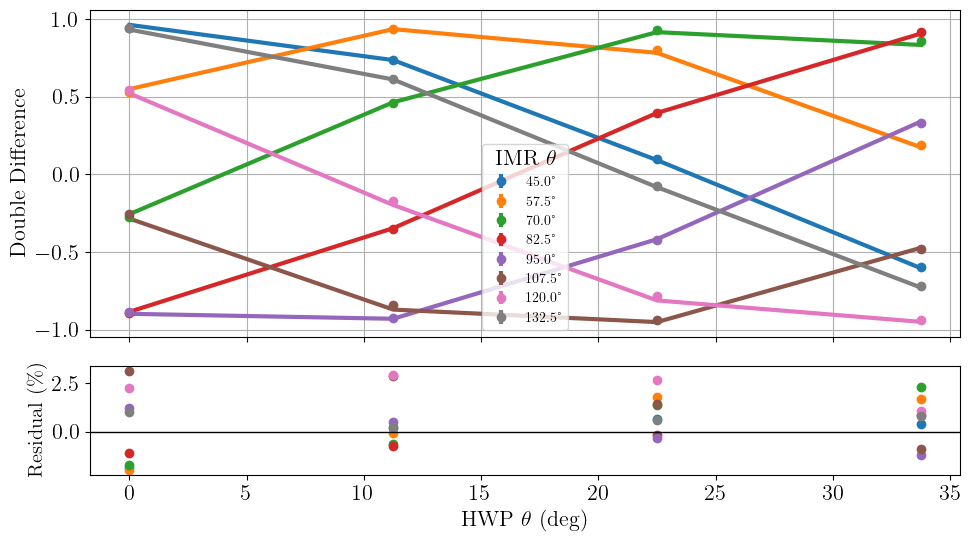

In [4]:

# Get our model retardances from Joost t Hart physical models

p = [0, 0]


# Define what is in the p list

system_parameters = [['pickoff', 'phi'], ['pickoff', 'delta_theta']]

# Generate our modeled left and right beam intensities

LR_intensities = model(p, system_parameters, system_mm, configuration_list)

# Process these into interleaved single norm differences and sums

diffs_sums = process_model(LR_intensities)

# Plot the modeled and observed values

fig, ax = plot_data_and_model(interleaved_values, interleaved_stds, diffs_sums,configuration_list, wavelength= wavelength_bins[4],include_sums=False,title='')
ax.tick_params(
    axis='x',
    direction='in',
    top=True,
    which='both',  
)
ax.tick_params(
    axis='y',
    direction='in',
    right=True,
    which='both',
)
ax.minorticks_on()
#fig.savefig('/Users/thomasmcintosh/Desktop/CHARIS-REU/overleaf_plots/MCMC_model_single_diff_vs_hwp_1931.png',bbox_inches='tight', dpi=600)




# Step 3: Fit for Retardances

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.1996e+06                                    1.13e+06    
       1              2         7.4246e+05      4.57e+05       3.61e+00       1.57e+05    
       2              3         7.2693e+05      1.55e+04       3.50e+00       2.43e+05    
       3              4         3.3898e+05      3.88e+05       5.83e-01       1.99e+06    
       4              5         1.5300e+05      1.86e+05       5.19e-01       1.84e+05    
       5              6         1.3363e+05      1.94e+04       1.51e+00       8.72e+05    
       6              7         1.2187e+05      1.18e+04       6.93e-02       8.35e+03    
       7              8         1.2148e+05      3.92e+02       4.27e-02       5.69e+03    
       8              9         1.2146e+05      1.17e+01       1.09e-02       4.17e+02    
       9             10         1.2146e+05      5.07e-02       3.61e-04       3.13e+00    

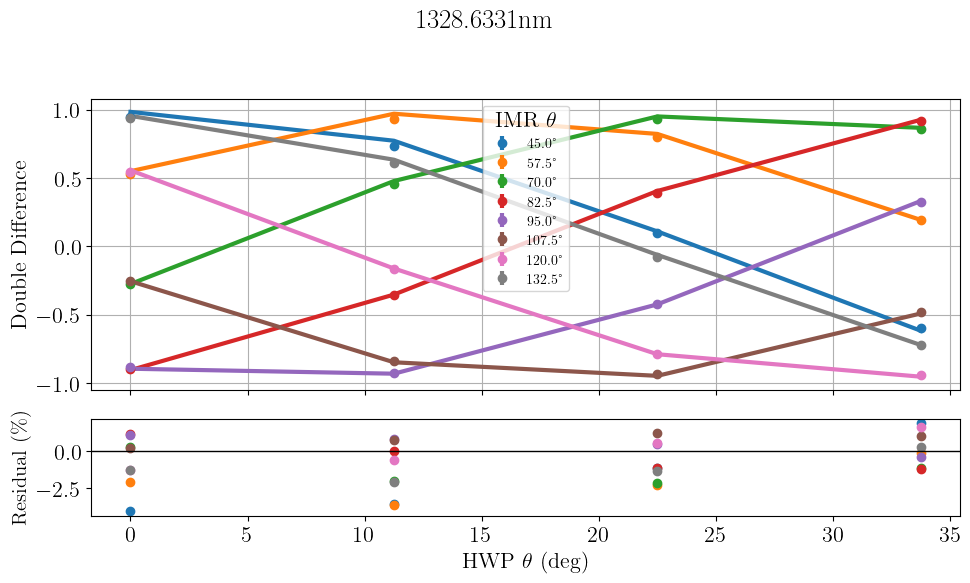

Updated Mueller Matrix:
[[ 0.67648123  0.6764057  -0.01010839  0.        ]
 [-0.67648123 -0.6764057   0.01010839  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.04061305086448508 0.018651130780057756
Error: [0.20611382 0.27343438 1.74297541]


/var/folders/2v/qmxm7kj51fg6kf7g36xrbysr0000gn/T/ipykernel_35432/3165291448.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig2.show()


In [4]:
# Test fitting with the wavelength bin we plotted earlier

error, fig2, ax2 = fit_CHARIS_Mueller_matrix_by_bin_pickoff(filepath, 4, 
    Path('/Users/thomasmcintosh/Desktop/CHARIS-REU/Fitting/naive_fitting/sys_dicts_with_pickoff/test.json'),
    )
ax2.tick_params(
    axis='x',
    direction='in',
    top=True,
    which='both',  
)
ax2.tick_params(
    axis='y',
    direction='in',
    right=True,
    which='both',
)
ax2.minorticks_on()
fig2.suptitle('')
fig2.show()
#fig2.savefig('/Users/thomasmcintosh/Desktop/CHARIS-REU/overleaf_plots/naive_model_single_diff_vs_hwp_1329.png',bbox_inches='tight', dpi=600)



Looks like our model improved! Note that the Joost't Hart paper used a more elaborate physical model, which I will incorporate later. These fits are a good starting point for more detailed models. Now we can fit for all bins and collect the errors.

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.3798e+06                                    3.66e+06    
       1              2         2.6523e+06      7.27e+05       1.91e+00       5.94e+05    
       2              3         2.5795e+06      7.28e+04       5.79e-01       4.54e+04    
       3              4         2.5710e+06      8.50e+03       6.66e-01       4.09e+05    
       4              5         2.5659e+06      5.13e+03       6.13e-01       4.90e+03    
       5              7         2.5648e+06      1.14e+03       5.46e-01       1.63e+05    
       6              8         2.5634e+06      1.35e+03       7.95e-01       1.42e+05    
       7              9         2.5628e+06      6.35e+02       4.57e-01       3.34e+04    
       8             10         2.5624e+06      3.39e+02       3.42e-01       3.77e+04    
       9             11         2.5624e+06      5.90e+01       5.84e-02       1.24e+01    

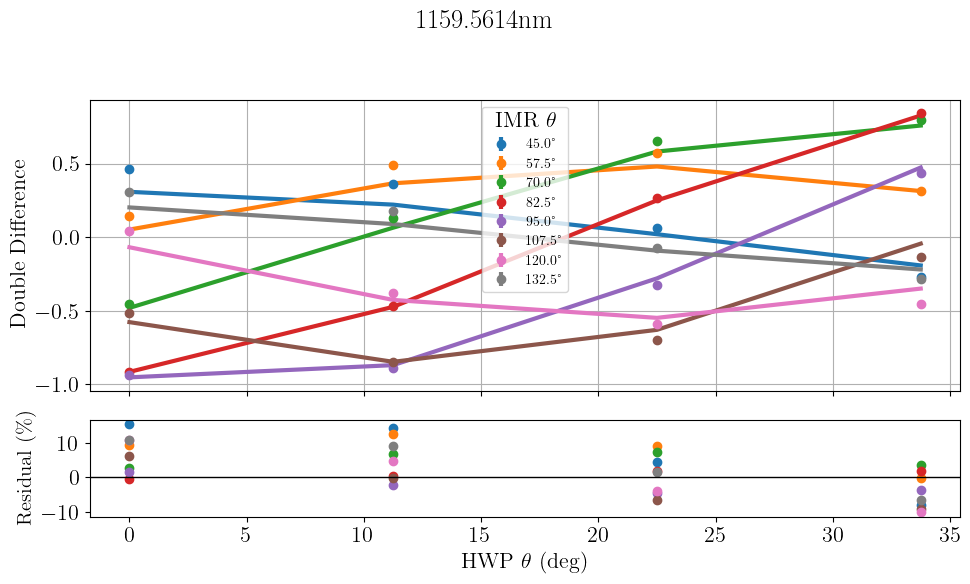

Updated Mueller Matrix:
[[ 0.6521268   0.65205399 -0.00974447  0.        ]
 [-0.6521268  -0.65205399  0.00974447  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.10143857215680724 0.1536976650167018
Error: [  3.41808426   0.69457605 207.18916156]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.9822e+06                                    1.92e+06    
       1              2         2.5920e+06      3.90e+05       1.14e+00       1.08e+05    
       2              4         2.5596e+06      3.24e+04       2.83e-01       3.64e+04    
       3              5         2.5395e+06      2.01e+04       5.30e-01       2.76e+05    
       4              6         2.5265e+06      1.30e+04       9.05e-01       4.37e+05    
       5              7         2.5227e+06      3.74e+03       2.49e-01       5.72e+03    
       6              

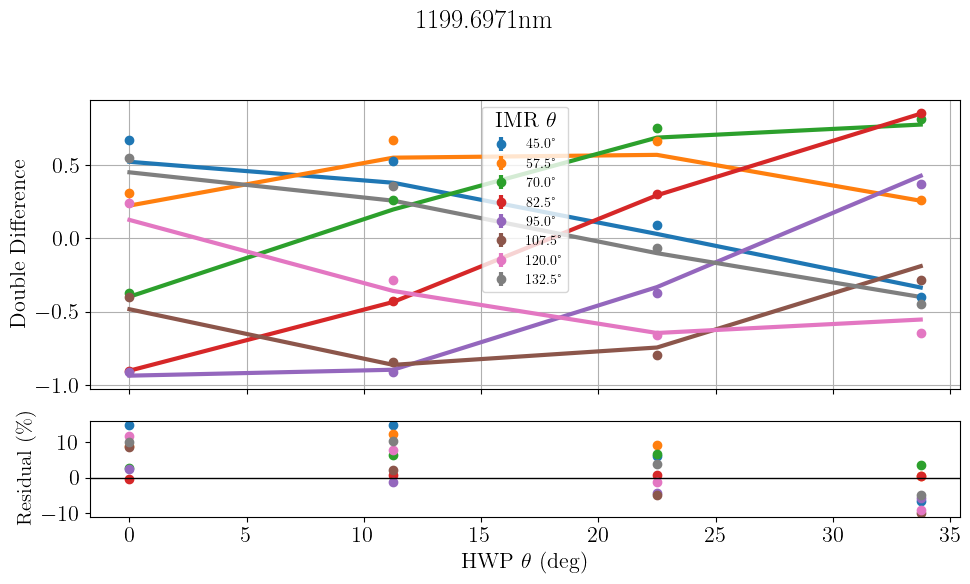

Updated Mueller Matrix:
[[ 0.74172122  0.74163841 -0.01108325  0.        ]
 [-0.74172122 -0.74163841  0.01108325  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.09755484696220021 0.14818241695516837
Error: [ 1.32640444  0.653858   31.42062957]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.4189e+06                                    1.28e+06    
       1              2         1.0854e+06      3.34e+05       7.25e-01       4.51e+04    
       2              3         1.0511e+06      3.43e+04       1.69e+00       2.76e+06    
       3              4         1.0165e+06      3.46e+04       1.19e-01       9.44e+04    
       4              5         1.0092e+06      7.22e+03       4.49e-02       3.40e+05    
       5              6         1.0081e+06      1.15e+03       1.96e-02       1.60e+04    
       6              7 

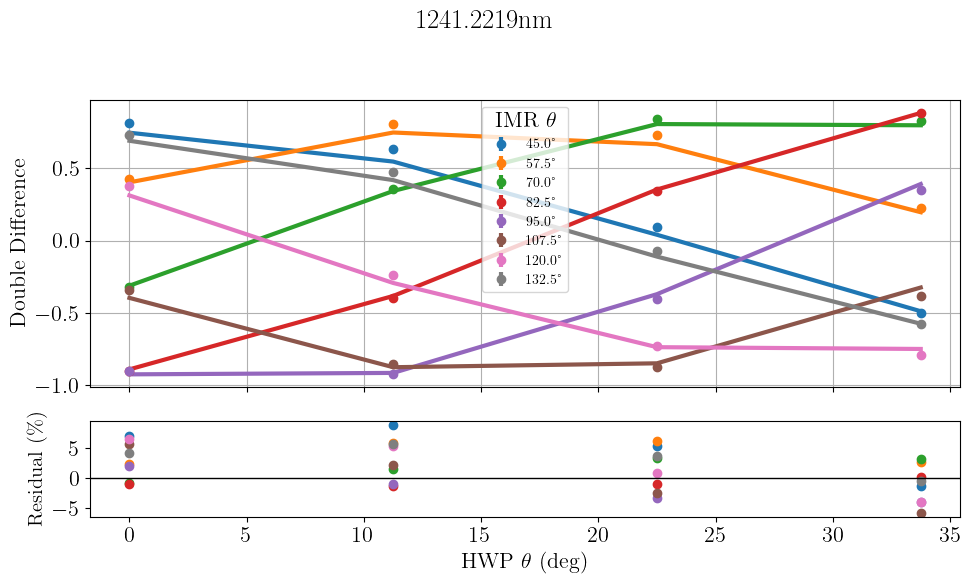

Updated Mueller Matrix:
[[ 0.82272952  0.82263766 -0.01229372  0.        ]
 [-0.82272952 -0.82263766  0.01229372  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.05711036313109524 0.08753274756674245
Error: [0.54740947 0.38747889 9.71817532]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.2623e+06                                    1.00e+06    
       1              2         9.0559e+05      3.57e+05       1.21e+00       6.80e+04    
       2              3         8.8461e+05      2.10e+04       2.13e+00       3.26e+06    
       3              5         8.2697e+05      5.76e+04       8.13e-02       1.06e+06    
       4              7         8.1936e+05      7.61e+03       4.01e-02       6.44e+04    
       5              8         8.1915e+05      2.01e+02       9.44e-03       1.14e+04    
       6              9    

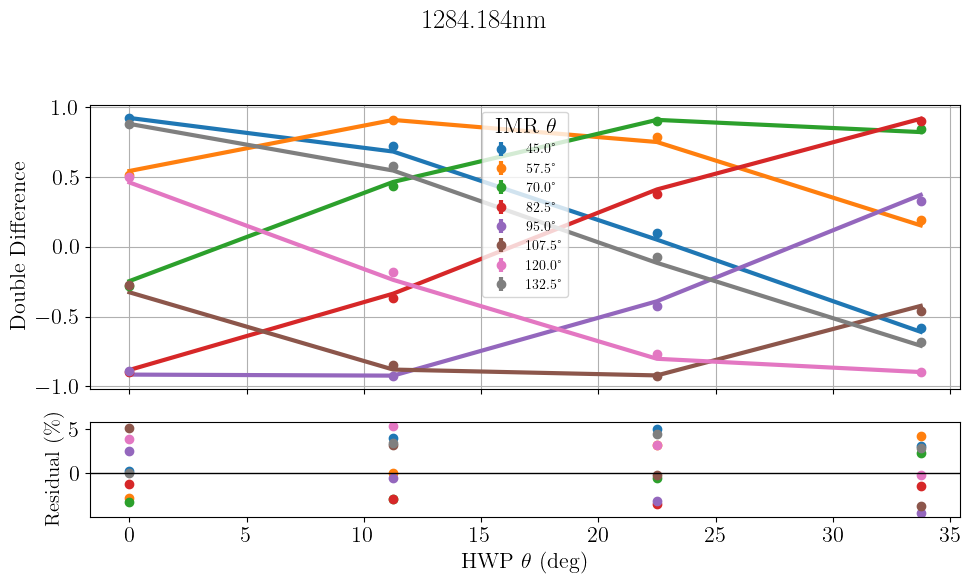

Updated Mueller Matrix:
[[ 0.87787044  0.87777243 -0.01311767  0.        ]
 [-0.87787044 -0.87777243  0.01311767  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.04499381178434564 0.05327308952637039
Error: [0.41298151 0.45198681 7.33412045]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.1647e+06                                    2.32e+06    
       1              2         1.2427e+06      9.22e+05       3.75e+00       2.64e+05    
       2              3         1.2262e+06      1.65e+04       3.48e+00       2.70e+05    
       3              4         6.0983e+05      6.16e+05       4.68e-01       3.26e+06    
       4              5         9.5906e+04      5.14e+05       6.39e-01       1.00e+06    
       5              6         6.1786e+04      3.41e+04       1.04e-01       5.93e+04    
       6              7    

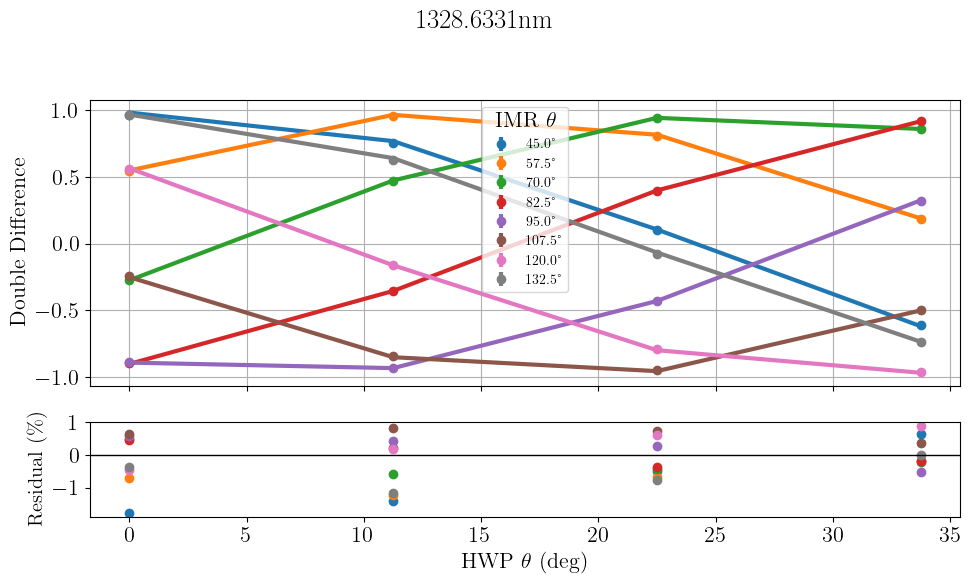

Updated Mueller Matrix:
[[ 0.38161668  0.38157407 -0.00570235  0.        ]
 [-0.38161668 -0.38157407  0.00570235  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.017676000773124256 0.008890921609957525
Error: [0.1256004  0.03304612 0.82003105]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.4717e+07                                    2.35e+07    
       1              2         7.0581e+06      7.66e+06       3.13e+00       4.94e+06    
       2              3         5.7284e+06      1.33e+06       3.28e+00       1.39e+07    
       3              4         4.4672e+06      1.26e+06       1.18e+00       2.28e+07    
       4              5         2.6078e+06      1.86e+06       5.18e-01       2.88e+06    
       5              6         2.4214e+06      1.86e+05       5.82e-01       9.71e+05    
       6              7  

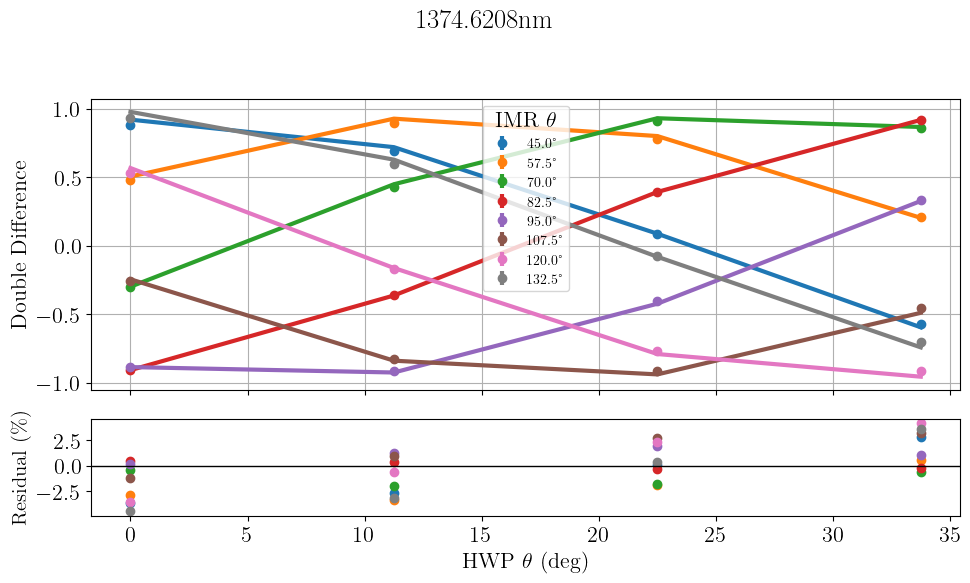

Updated Mueller Matrix:
[[ 0.49707717  0.49702167 -0.00742763  0.        ]
 [-0.49707717 -0.49702167  0.00742763  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.04478313415394264 0.041235746800259654
Error: [0.29528658 0.08164454 3.2584841 ]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         8.8861e+06                                    2.03e+07    
       1              2         3.3015e+06      5.58e+06       2.75e+00       4.44e+06    
       2              3         2.2081e+06      1.09e+06       2.38e+00       4.21e+06    
       3              4         1.6002e+06      6.08e+05       1.26e+00       6.92e+06    
       4              5         1.2508e+06      3.49e+05       3.59e-01       7.78e+05    
       5              6         1.2107e+06      4.01e+04       5.12e-01       5.74e+05    
       6              7   

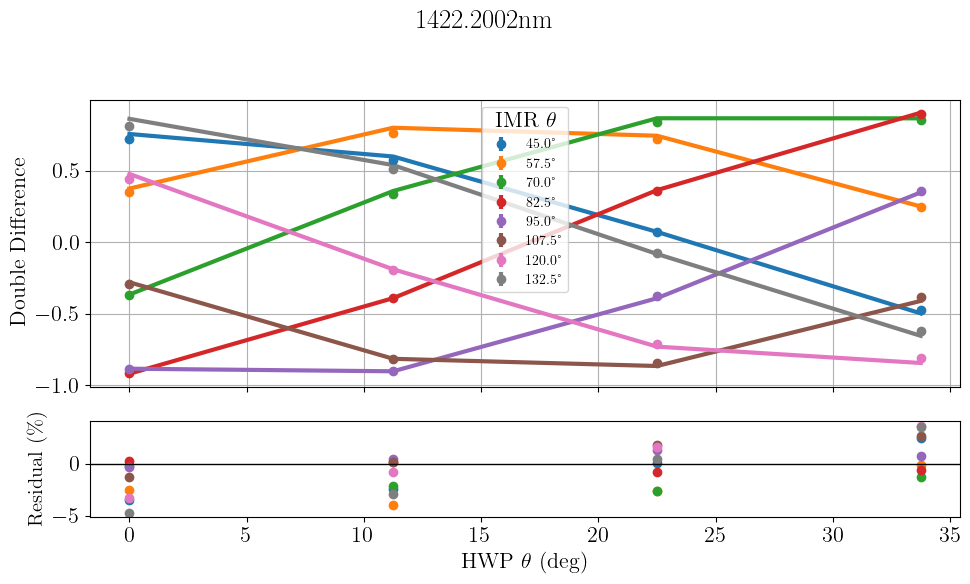

Updated Mueller Matrix:
[[ 0.47504073  0.47498769 -0.00709835  0.        ]
 [-0.47504073 -0.47498769  0.00709835  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.04707082512355387 0.03694270868007732
Error: [0.18799427 0.07919989 3.14884093]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         8.5492e+06                                    2.66e+07    
       1              2         2.0769e+06      6.47e+06       2.54e+00       5.80e+06    
       2              3         9.3282e+05      1.14e+06       1.86e+00       1.36e+06    
       3              5         7.2388e+05      2.09e+05       3.20e-01       1.73e+06    
       4              6         5.1271e+05      2.11e+05       6.19e-01       8.71e+05    
       5              7         4.9577e+05      1.69e+04       1.82e-01       1.11e+05    
       6              9    

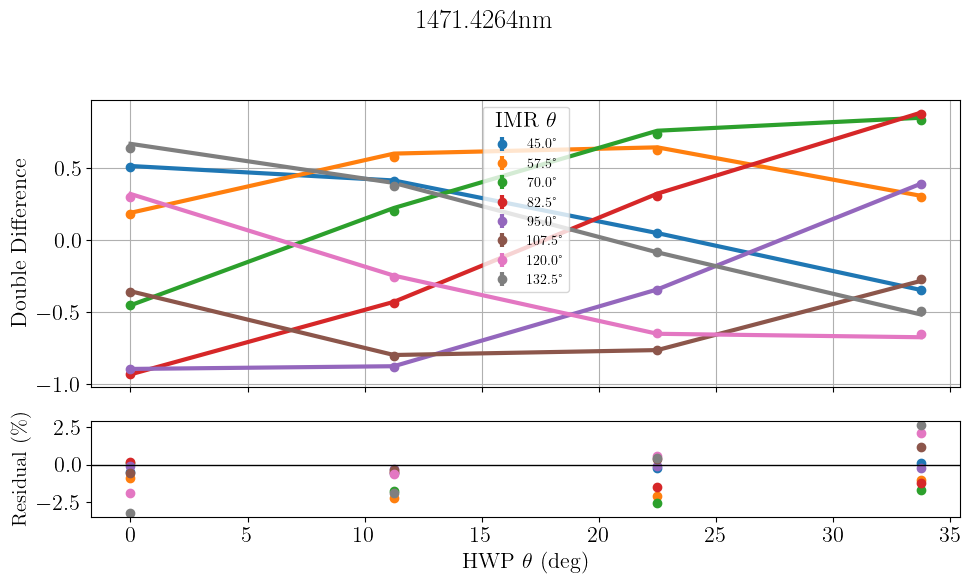

Updated Mueller Matrix:
[[ 0.50627832  0.5062218  -0.00756512  0.        ]
 [-0.50627832 -0.5062218   0.00756512  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.031875772698366944 0.02611585956847473
Error: [0.09488064 0.05128197 2.79090822]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         7.7521e+06                                    2.78e+07    
       1              2         1.5253e+06      6.23e+06       2.42e+00       6.07e+06    
       2              3         5.1865e+05      1.01e+06       1.55e+00       1.35e+06    
       3              4         3.6974e+05      1.49e+05       1.00e+00       8.74e+05    
       4              5         3.4745e+05      2.23e+04       3.71e-01       3.07e+04    
       5              7         3.4590e+05      1.55e+03       1.69e-01       2.70e+04    
       6              8   

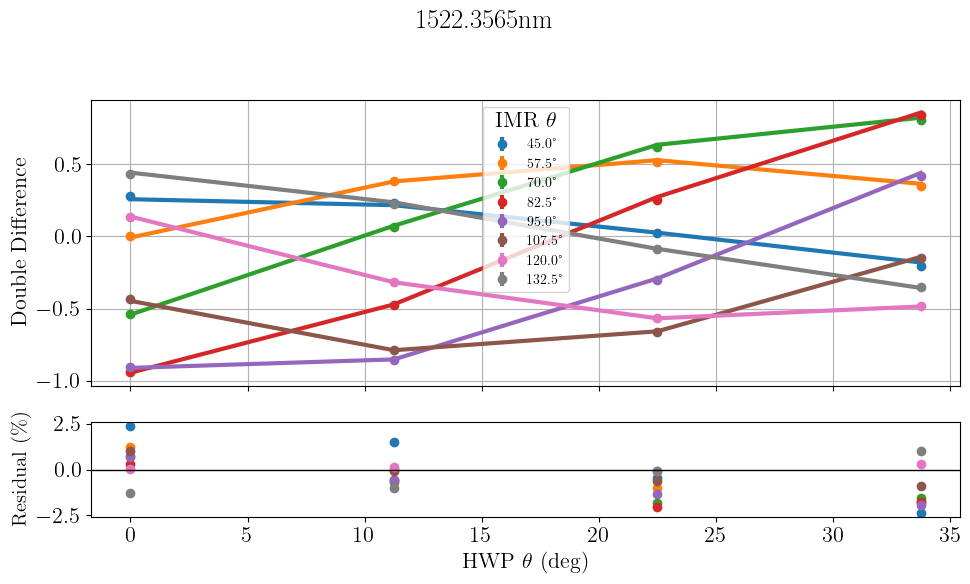

Updated Mueller Matrix:
[[ 0.5381584   0.53809831 -0.00804149  0.        ]
 [-0.5381584  -0.53809831  0.00804149  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.02346256600500568 0.023805880605061946
Error: [0.0945867  0.04847105 6.08105009]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.1938e+07                                    3.49e+07    
       1              2         4.2607e+06      7.68e+06       2.44e+00       7.80e+06    
       2              3         2.9166e+06      1.34e+06       1.52e+00       1.78e+06    
       3              4         2.7044e+06      2.12e+05       8.92e-01       6.76e+05    
       4              5         2.6836e+06      2.08e+04       5.86e-01       8.59e+05    
       5              6         2.6742e+06      9.43e+03       5.14e-01       2.97e+05    
       6              8   

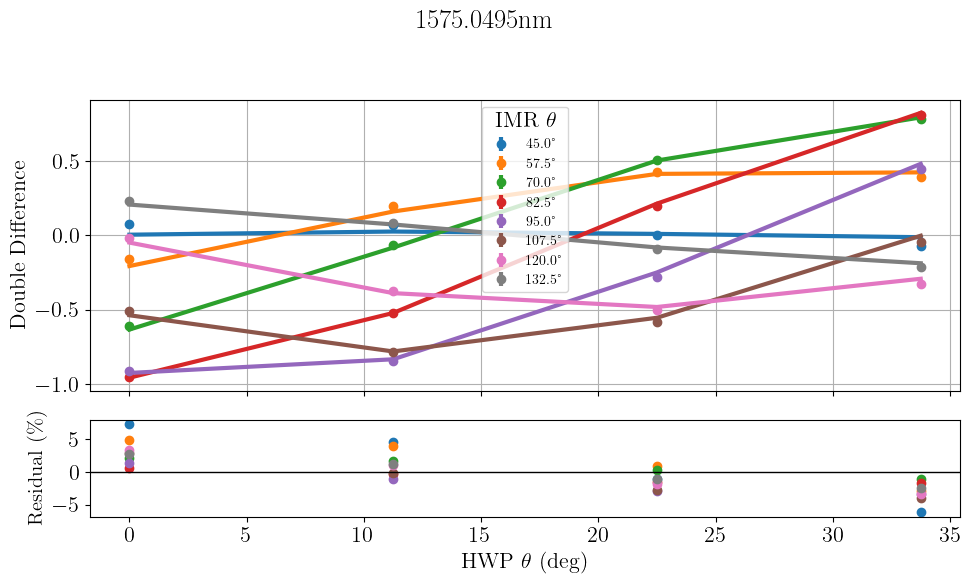

Updated Mueller Matrix:
[[ 0.53531892  0.53525915 -0.00799906  0.        ]
 [-0.53531892 -0.53525915  0.00799906  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.062178479528927376 0.07314015164783028
Error: [  1.79127217   0.2049978  139.4637995 ]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.9128e+07                                    4.38e+07    
       1              2         9.7437e+06      9.38e+06       2.45e+00       9.57e+06    
       2              3         7.4379e+06      2.31e+06       1.59e+00       3.12e+06    
       3              4         7.1120e+06      3.26e+05       1.13e+00       3.55e+06    
       4              5         6.9121e+06      2.00e+05       2.09e-01       2.74e+05    
       5              7         6.8833e+06      2.88e+04       2.92e-01       3.59e+05    
       6            

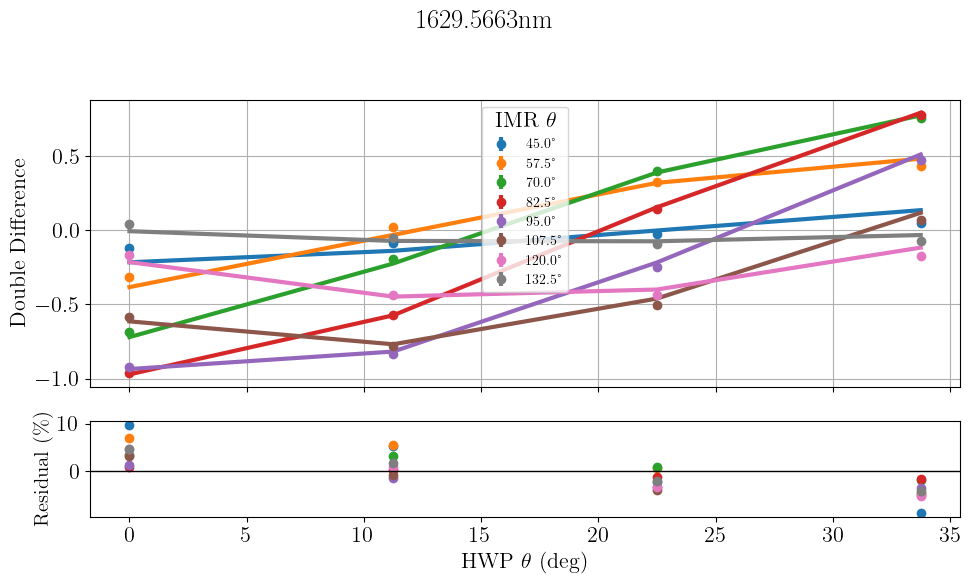

Updated Mueller Matrix:
[[ 0.45775166  0.45770056 -0.00684     0.        ]
 [-0.45775166 -0.45770056  0.00684     0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.08846467675675485 0.09664985930453311
Error: [ 1.65797216  0.29448705 86.23886914]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.1779e+07                                    3.71e+07    
       1              2         1.3794e+07      7.99e+06       2.44e+00       7.32e+06    
       2              3         1.1631e+07      2.16e+06       1.66e+00       3.39e+06    
       3              4         1.0851e+07      7.79e+05       1.25e+00       2.56e+05    
       4              6         1.0784e+07      6.68e+04       3.09e-01       5.50e+05    
       5              7         1.0780e+07      4.81e+03       8.55e-01       6.53e+06    
       6              8 

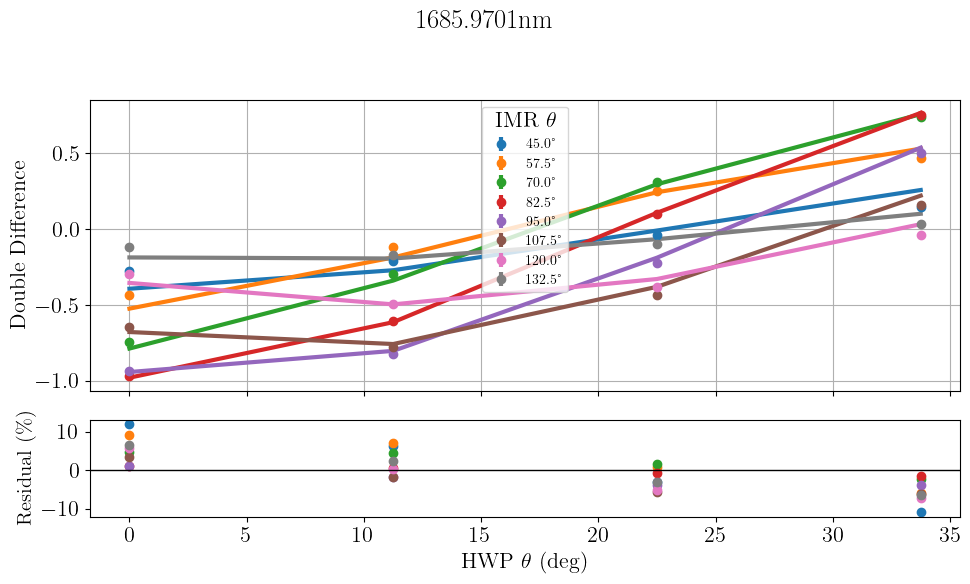

Updated Mueller Matrix:
[[ 0.39536921  0.39532506 -0.00590785  0.        ]
 [-0.39536921 -0.39532506  0.00590785  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.11006198118727523 0.11966249235590892
Error: [ 1.53564057  0.39558129 58.29570238]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.0465e+07                                    3.59e+07    
       1              2         2.2289e+07      8.18e+06       2.47e+00       5.69e+06    
       2              3         2.1466e+07      8.23e+05       1.19e+00       1.70e+06    
       3              4         1.9458e+07      2.01e+06       1.65e+00       7.73e+06    
       4              5         1.9008e+07      4.51e+05       8.50e-01       1.34e+06    
       5              6         1.8786e+07      2.22e+05       8.89e-01       9.60e+06    
       6              7 

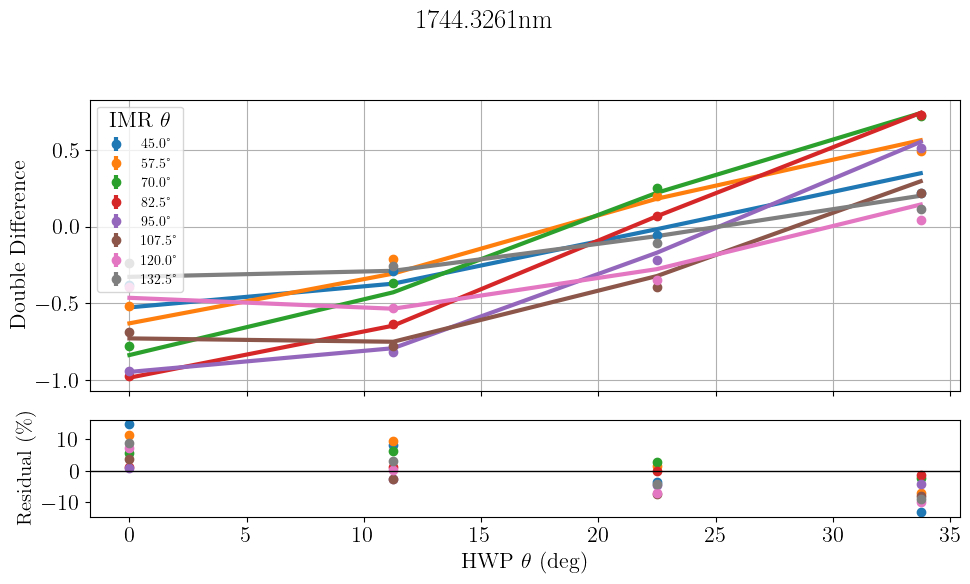

Updated Mueller Matrix:
[[ 0.35006811  0.35002902 -0.00523093  0.        ]
 [-0.35006811 -0.35002902  0.00523093  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.1320926691752923 0.1485533412662337
Error: [ 1.3807072   0.53935462 37.57825328]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         6.7062e+07                                    5.95e+07    
       1              2         5.2006e+07      1.51e+07       2.55e+00       5.39e+06    
       2              3         4.9689e+07      2.32e+06       2.64e-01       7.50e+06    
       3              4         4.2764e+07      6.92e+06       1.89e+00       3.35e+06    
       4              5         4.1308e+07      1.46e+06       8.22e-01       1.07e+06    
       5              6         4.0650e+07      6.59e+05       5.72e-01       3.74e+05    
       6              7   

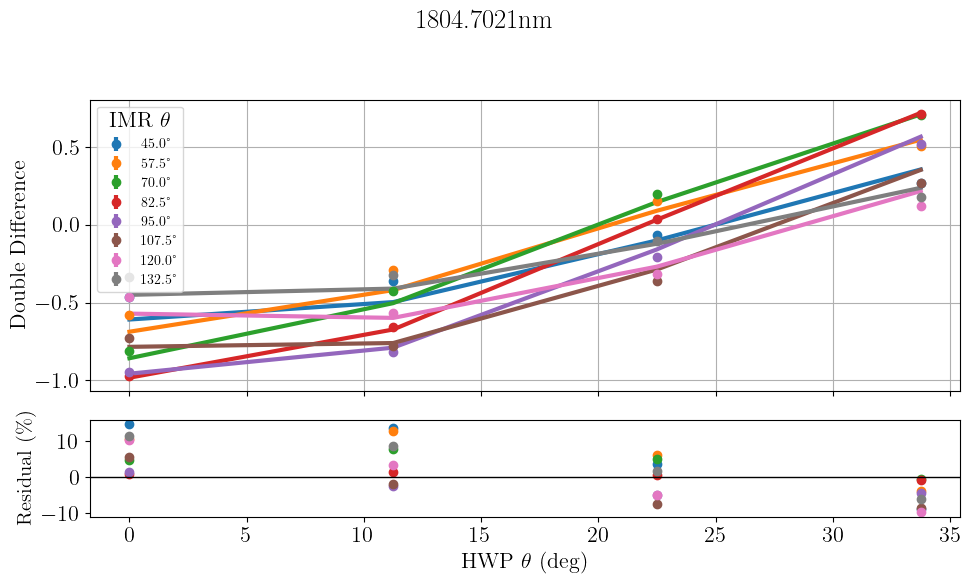

Updated Mueller Matrix:
[[ 0.03723046  0.0372263  -0.00055632  0.        ]
 [-0.03723046 -0.0372263   0.00055632  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.09867922856094002 0.1476791459944813
Error: [0.37681798 0.44838912 6.95620401]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.2112e+08                                    1.64e+08    
       1              2         1.7488e+08      4.62e+07       2.59e+00       1.58e+07    
       2              3         1.3990e+08      3.50e+07       1.94e+00       1.28e+07    
       3              4         1.3490e+08      5.00e+06       7.70e-01       4.15e+06    
       4              5         1.3250e+08      2.41e+06       6.41e-01       1.23e+06    
       5              6         1.3165e+08      8.47e+05       2.38e-01       4.41e+05    
       6              7     

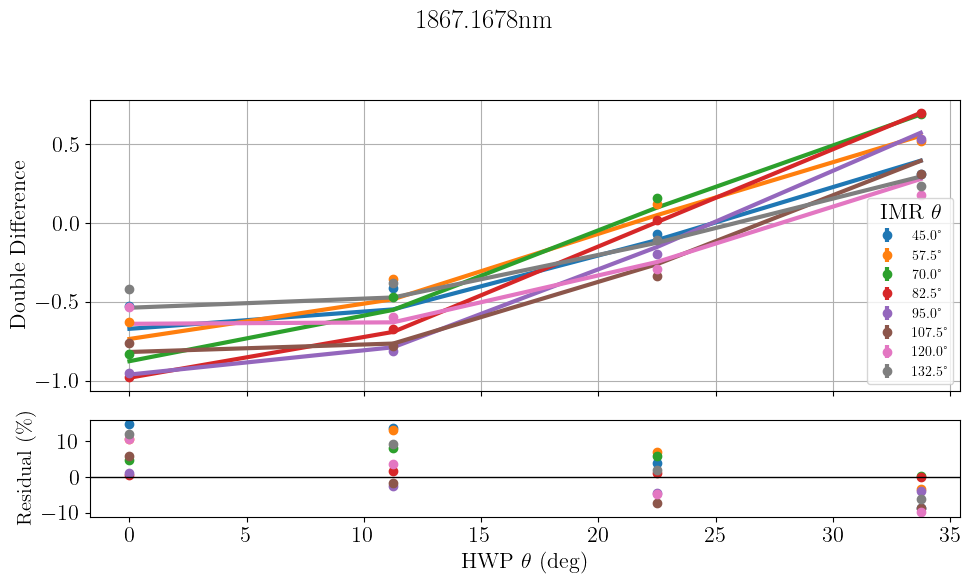

Updated Mueller Matrix:
[[ 0.02809415  0.02809101 -0.0004198   0.        ]
 [-0.02809415 -0.02809101  0.0004198   0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.09949038731655246 0.1467022809790599
Error: [0.4505599  0.43960346 7.02345339]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.0186e+08                                    5.97e+07    
       1              2         8.2703e+07      1.92e+07       2.64e+00       7.50e+06    
       2              3         6.6455e+07      1.62e+07       2.08e+00       5.43e+06    
       3              4         6.4269e+07      2.19e+06       7.20e-01       1.87e+06    
       4              5         6.3206e+07      1.06e+06       6.21e-01       6.28e+05    
       5              6         6.2844e+07      3.62e+05       2.22e-01       1.86e+05    
       6              7     

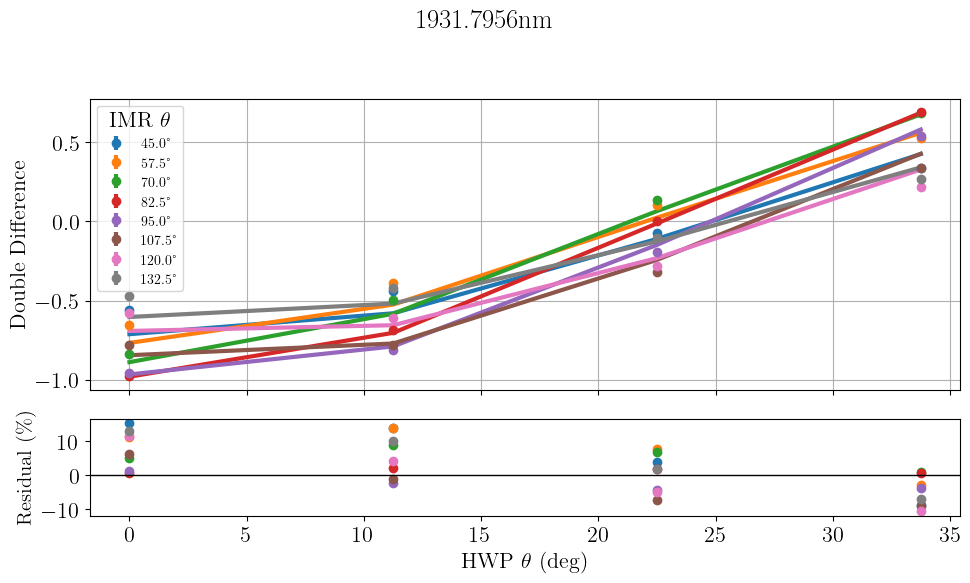

Updated Mueller Matrix:
[[ 0.02415996  0.02415726 -0.00036101  0.        ]
 [-0.02415996 -0.02415726  0.00036101  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.10780055716419362 0.153237667352343
Error: [0.45973132 0.45828919 7.42057319]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         8.9509e+07                                    4.17e+07    
       1              2         7.4229e+07      1.53e+07       2.77e+00       7.41e+06    
       2              3         6.1364e+07      1.29e+07       1.89e+00       6.44e+06    
       3              4         5.8545e+07      2.82e+06       7.83e-01       2.04e+06    
       4              5         5.7589e+07      9.56e+05       6.57e-01       6.52e+05    
       5              6         5.7040e+07      5.50e+05       4.13e-01       2.69e+05    
       6              7      

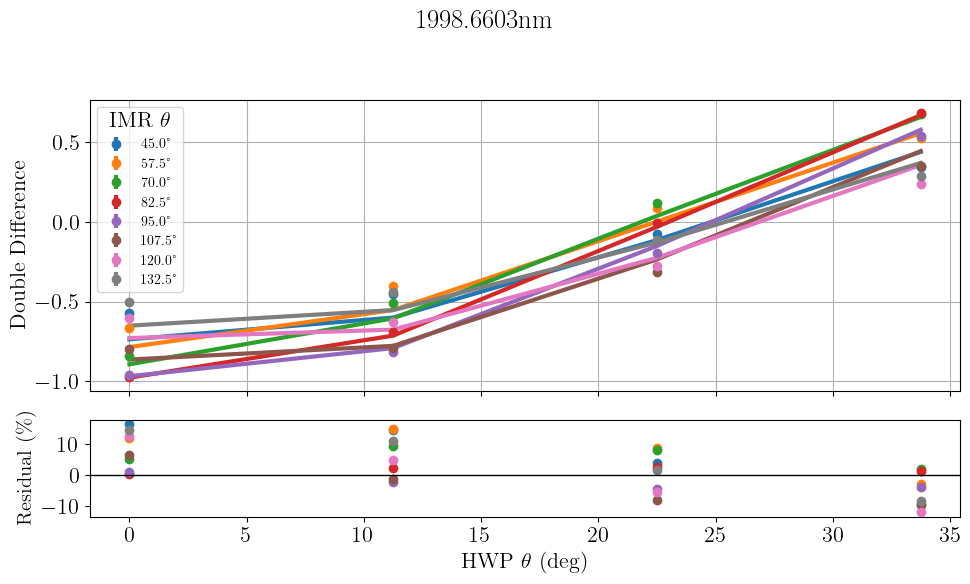

Updated Mueller Matrix:
[[ 0.02252347  0.02252095 -0.00033656  0.        ]
 [-0.02252347 -0.02252095  0.00033656  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.11998862925750325 0.16406036903353705
Error: [0.35967019 0.47992857 7.7967419 ]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         8.2646e+07                                    3.23e+07    
       1              2         6.9541e+07      1.31e+07       2.88e+00       9.37e+06    
       2              3         5.9918e+07      9.62e+06       1.73e+00       7.06e+06    
       3              4         5.5440e+07      4.48e+06       9.29e-01       2.31e+06    
       4              5         5.4471e+07      9.70e+05       6.08e-01       7.85e+05    
       5              6         5.3716e+07      7.54e+05       5.85e-01       3.30e+05    
       6              7    

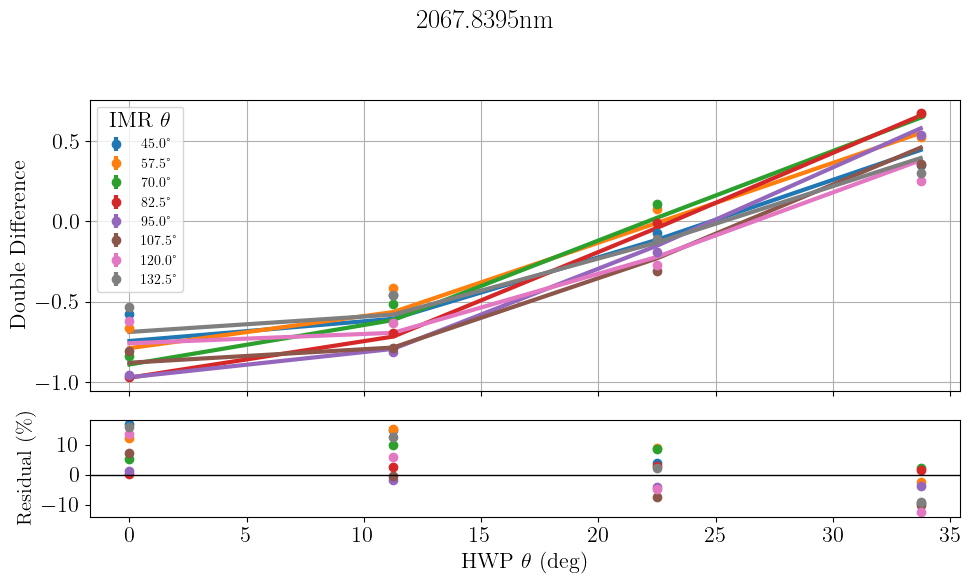

Updated Mueller Matrix:
[[ 0.02148961  0.02148721 -0.00032111  0.        ]
 [-0.02148961 -0.02148721  0.00032111  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.12659270744510814 0.1684419854581325
Error: [0.31578132 0.47177113 7.77237157]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         6.8523e+07                                    2.30e+07    
       1              2         5.8596e+07      9.93e+06       2.96e+00       8.97e+06    
       2              3         5.2165e+07      6.43e+06       1.55e+00       6.17e+06    
       3              4         4.7882e+07      4.28e+06       1.05e+00       2.04e+06    
       4              5         4.7035e+07      8.47e+05       6.69e-01       7.30e+05    
       5              6         4.6322e+07      7.14e+05       6.70e-01       3.74e+05    
       6              7     

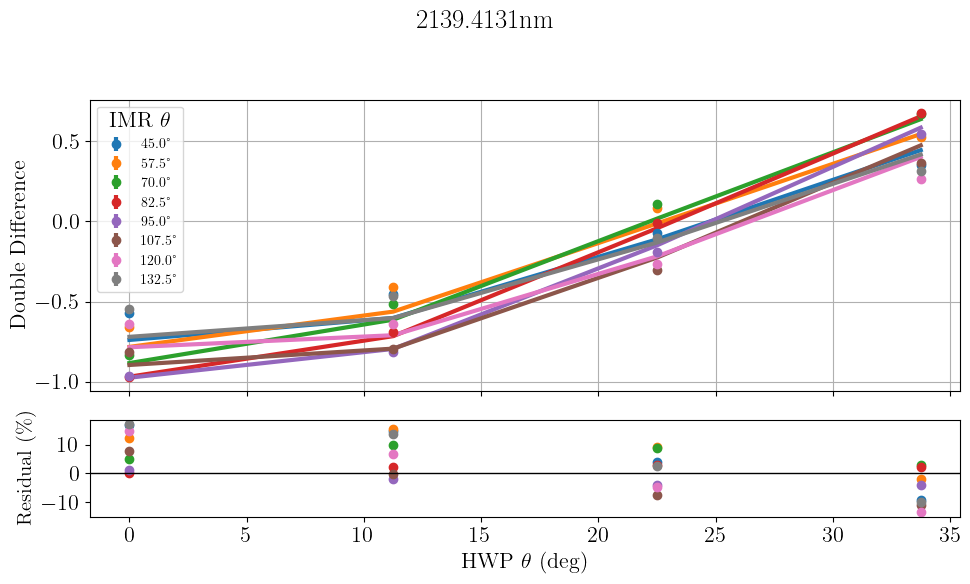

Updated Mueller Matrix:
[[ 0.02208456  0.0220821  -0.00033     0.        ]
 [-0.02208456 -0.0220821   0.00033     0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.13679124495640682 0.1719370362605761
Error: [0.31379373 0.46435631 7.75068604]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         6.2632e+07                                    1.73e+07    
       1              2         5.4948e+07      7.68e+06       3.00e+00       8.02e+06    
       2              3         4.9013e+07      5.93e+06       1.53e+00       5.57e+06    
       3              4         4.6716e+07      2.30e+06       9.03e-01       1.93e+06    
       4              5         4.5828e+07      8.88e+05       8.30e-01       7.34e+05    
       5              6         4.5181e+07      6.47e+05       6.58e-01       3.62e+05    
       6              7     

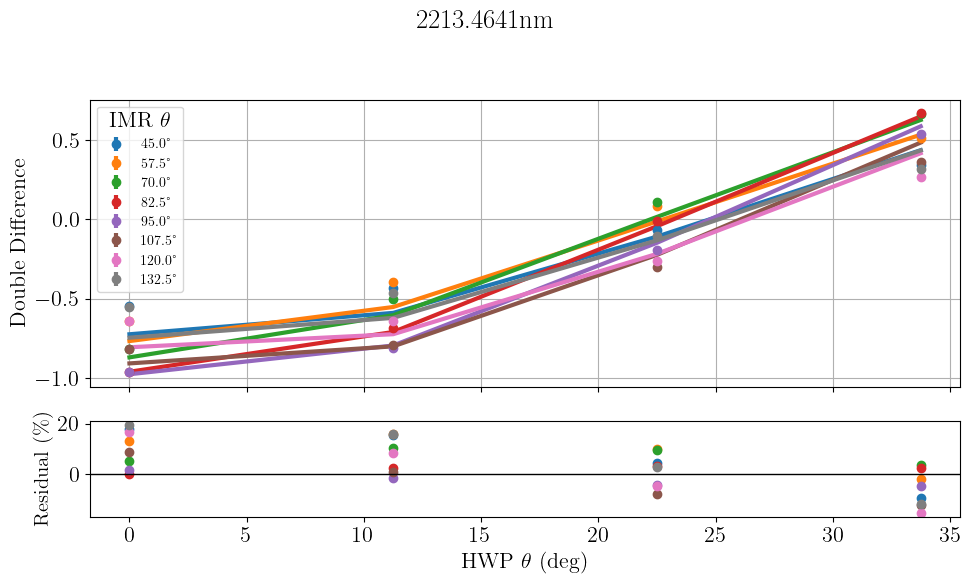

Updated Mueller Matrix:
[[ 0.02403498  0.0240323  -0.00035915  0.        ]
 [-0.02403498 -0.0240323   0.00035915  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.15239997192745813 0.19315960026559553
Error: [0.32524995 0.46877148 7.92412271]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.7626e+07                                    1.15e+07    
       1              2         4.2646e+07      4.98e+06       3.03e+00       6.00e+06    
       2              3         3.8792e+07      3.85e+06       1.45e+00       4.28e+06    
       3              4         3.6965e+07      1.83e+06       9.72e-01       1.56e+06    
       4              5         3.6182e+07      7.84e+05       9.12e-01       5.70e+05    
       5              6         3.5703e+07      4.79e+05       6.00e-01       2.49e+05    
       6              7    

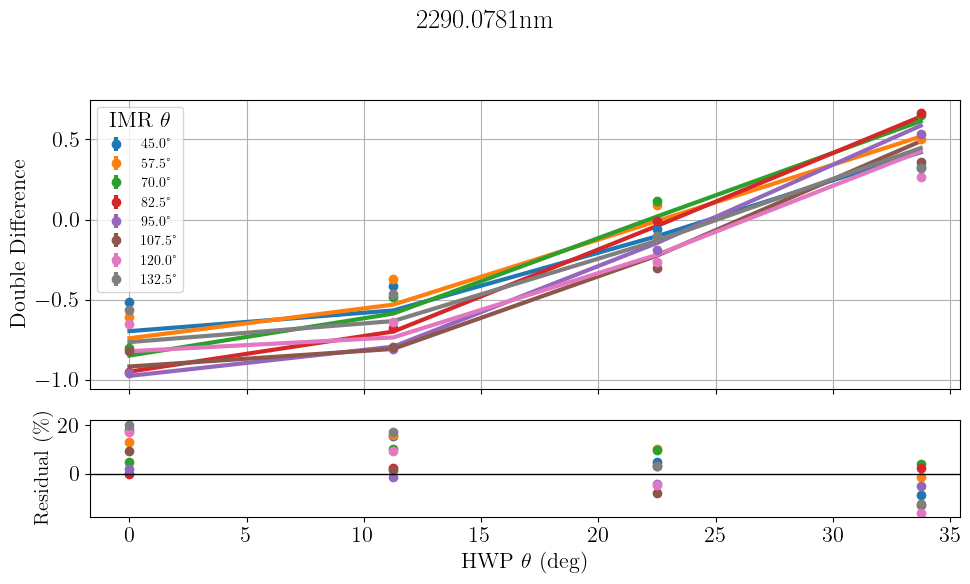

Updated Mueller Matrix:
[[ 0.02734707  0.02734402 -0.00040864  0.        ]
 [-0.02734707 -0.02734402  0.00040864  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.16107394518251722 0.20164837172129224
Error: [0.32584644 0.44148753 7.57819905]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.0962e+07                                    8.65e+06    
       1              2         3.7829e+07      3.13e+06       3.05e+00       3.85e+06    
       2              3         3.5146e+07      2.68e+06       1.49e+00       3.19e+06    
       3              4         3.3665e+07      1.48e+06       1.18e+00       1.24e+06    
       4              5         3.2918e+07      7.46e+05       9.26e-01       3.55e+05    
       5              6         3.2625e+07      2.94e+05       3.82e-01       1.46e+05    
       6              7    

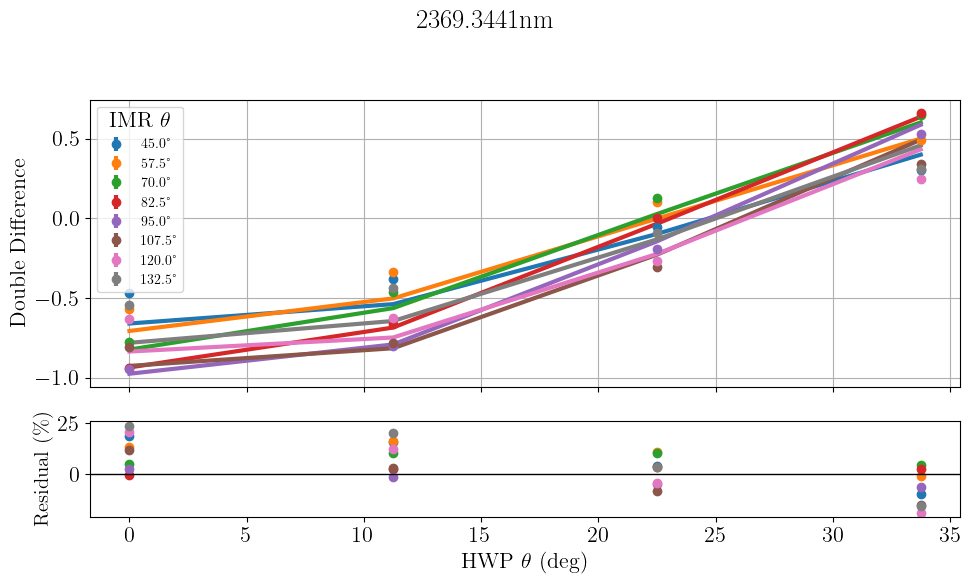

Updated Mueller Matrix:
[[ 0.03224323  0.03223963 -0.0004818   0.        ]
 [-0.03224323 -0.03223963  0.0004818   0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.18598332200076073 0.2384420080953359
Error: [0.35864621 0.44025343 7.71260504]


In [5]:
# Fit all 22 wavelength bins
errors = []
for bin in range(0,22):
    error = fit_CHARIS_Mueller_matrix_by_bin_pickoff(
        Path(f'datacsvs/csvs_nopickoff/charis_cube_info_bin{bin}_no_pickoff.csv'),
        bin,
        Path(f'/Users/thomasmcintosh/Desktop/CHARIS-REU/Fitting/naive_fitting/system_dicts_no_pickoff_extra_eps/bin{bin}.json')
        
    )[0]
    errors.append(error)


(array([5.00000000e-13, 5.00000000e-13, 5.75021932e-13, 9.53886575e-10,
        5.97250499e-01, 4.60279604e-01, 4.49114419e-01, 3.30253738e-01,
        1.60103336e-01, 5.00680869e-13, 5.04429712e-13, 5.00000000e-13,
        5.00395663e-13, 8.11137770e-01, 8.28438588e-01, 8.35174452e-01,
        8.41363531e-01, 8.46217597e-01, 8.43375449e-01, 8.36454547e-01,
        8.26963054e-01, 8.14032734e-01]),
 <Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'pickoff: epsilon vs wavelength'}, xlabel='Wavelength (nm)', ylabel='epsilon'>)

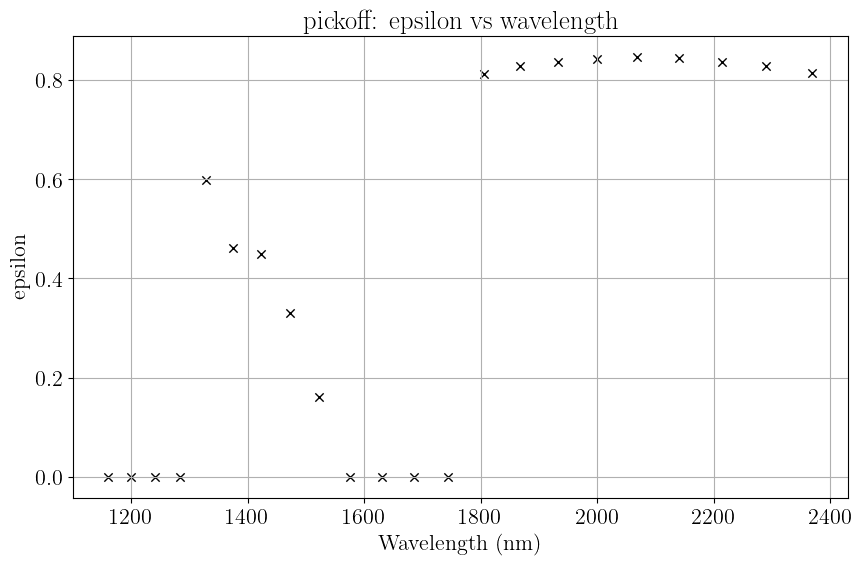

In [7]:
from vampires_calibration.plotting import plot_config_dict_vs_wavelength
jsondir = Path('/Users/thomasmcintosh/Desktop/CHARIS-REU/Fitting/naive_fitting/system_dicts_no_pickoff_extra_eps')
plot_config_dict_vs_wavelength('pickoff','epsilon',jsondir)

In [4]:
# find average error
errors = np.array(errors)
print('pickoff_ret', np.mean(errors[:,0]))
print('pickoff_offset',np.mean(errors[:,1]))



    

pickoff_ret 0.8591047254114081
pickoff_offset 25.11930543197441


In [7]:
# Now let's make a dataframe of our data, this model data function can be changed easily to include
# whatever parameters you're fitting
from vampires_calibration.plotting import model_data
json_dir = '/Users/thomasmcintosh/Desktop/CHARIS-REU/Fitting/naive_fitting/sys_dics_justrets'
df = model_data(json_dir)
df

,wavelength_bin,pickphi,pickoffoff
0,1159.5614,0.081807,5.000000
1,1199.6971,0.194780,5.000000
2,1241.2219,0.235090,5.000000
3,1284.1840,0.216184,5.000000
4,1328.6331,0.959240,-3.395535
5,1374.6208,0.683815,-3.252282
6,1422.2002,2.588989,-0.450526
7,1471.4264,2.373945,-0.312329
8,1522.3565,1.130781,-0.268333
9,1575.0495,0.065208,-5.000000


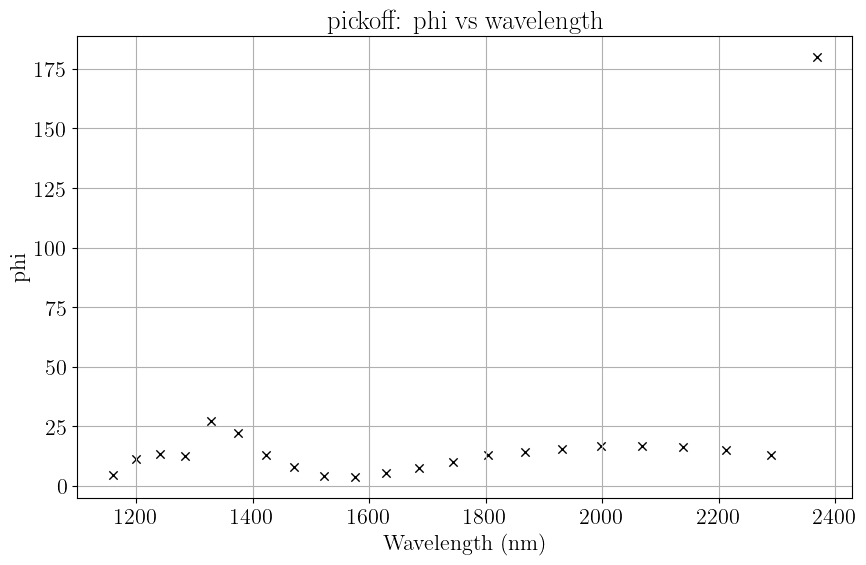

In [6]:
from vampires_calibration.plotting import plot_config_dict_vs_wavelength
params,fig_pick, ax_pick = plot_config_dict_vs_wavelength('pickoff','phi','/Users/thomasmcintosh/Desktop/CHARIS-REU/Fitting/naive_fitting/sys_dics_justrets')

# Step 4: Refine Retardance Model

This step depends heavily on what components you are fitting to. I'm going to make the IMR and HWP retardances a function of wavelength using the Joost t Hart 2021 physical models. I'll use the parameters we just fitted as my dataset. 

In [11]:
def phys_model_chisq(p0, wavelengths, retardances_hwp, errors_hwp, retardances_imr,errors_imr):
    """
    Calculate the chi squared for the physical model of CHARIS.
    
    Parameters:
    -----------
    p0 : list
        List of parameters [w_sio2, w_mgf2, d].
    
    wavelengths : numpy array
        Array of wavelengths that are in the data.

    retardances_hwp : list or numpy array
        Retardances of the HWP at the specified wavelengths.

    errors_hwp : list or numpy array
        Errors associated with the HWP retardances.

    retardances_imr : list or numpy array
        Retardances of the IMR at the specified wavelengths.
    
    errors_imr : list or numpy array
        Errors associated with the IMR retardances.
    
    Returns:
    --------
    float
        The chi squared value.
    """
    # Get model retardances
    model_hwp = HWP_retardance(wavelengths, p0[0], p0[1])
    model_imr = IMR_retardance(wavelengths, p0[2])
    # Calculate residuals
    residuals_hwp = (retardances_hwp - model_hwp) / errors_hwp
    residuals_imr = (retardances_imr - model_imr) / errors_imr
    # Calculate log-likelihood
    chisq_hwp = np.sum(residuals_hwp**2)
    chisq_imr = np.sum(residuals_imr**2)
    return chisq_hwp + chisq_imr

In [12]:

# Minimizing the physical model

p0 = [1.623, 1.268, 262.56] # starting guesses from Joost t Hart 2021
wavelengths = wavelength_bins # CHARIS wavelength bins

# Defining reasonable bounds (these values shouldn't have changed much)
  
wsio2_bounds = (0.9*p0[0], 1.1*p0[0])
wmgf2_bounds = (0.9*p0[1], 1.1*p0[1])
d_bounds = (0.9*p0[2], 1.1*p0[2])
bounds = [wsio2_bounds, wmgf2_bounds, d_bounds]

# Extract our retardances and errors from the data
errors = np.array(errors)
hwp_retardances = df['hwp_retardance'].values
imr_retardance = df['imr_retardance'].values
hwp_errors = errors[:,0] 
imr_errors = errors[:,1]  

# Use a while loop to iteratively minimize the chi squared function
# Counters for iterative fitting

iteration = 1
previous_chisq = 1000000
new_chisq = 0

while abs(previous_chisq-new_chisq)> 0.01*abs(previous_chisq):
        previous_chisq = new_chisq
        result = minimize(phys_model_chisq,p0, args=(wavelengths, hwp_retardances, hwp_errors, imr_retardance, imr_errors), bounds=bounds)
        p0 = result.x
        new_chisq = result.fun
        iteration += 1
        print(result)

hess_inv = result.hess_inv


  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 2437.668321379841
        x: [ 1.663e+00  1.298e+00  2.584e+02]
      nit: 8
      jac: [ 4.302e+00 -5.756e+00 -2.547e-03]
     nfev: 80
     njev: 20
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 2437.6683213792157
        x: [ 1.663e+00  1.298e+00  2.584e+02]
      nit: 1
      jac: [ 9.732e-03  1.055e-02 -1.546e-03]
     nfev: 12
     njev: 3
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


That's It! The fit is updated. However, in the Hart 2021 paper, a degeneracy in wavelength bin 4 was noted. Because of this, I will redo the fit to see if the model fits better. 

In [13]:
# Redo the fit without the degenerate point (bin 4)

wavelengths2 = np.delete(wavelength_bins, 4)
p0_2 = [1.623, 1.268, 262.56] # starting guesses from Joost t Hart 2021

# Defining reasonable bounds (these values shouldn't have changed much)

wsio2_bounds2 = (0.9*p0_2[0], 1.1*p0_2[0])
wmgf2_bounds2 = (0.9*p0_2[1], 1.1*p0_2[1])
d_bounds2 = (0.9*p0_2[2], 1.1*p0_2[2])
bounds2 = [wsio2_bounds2, wmgf2_bounds2, d_bounds2]

# Extract our retardances and errors from the data
errors2 = np.delete(np.array(errors), 4, axis=0)
hwp_retardances2 = df['hwp_retardance'].values
imr_retardance2 = df['imr_retardance'].values
hwp_errors2 = errors2[:,0] 
imr_errors2 = errors2[:,1]  

# Remove the corresponding retardances for the removed bin

hwp_retardances2 = np.delete(hwp_retardances2, 4)
imr_retardance2= np.delete(imr_retardance2,4)

# Use a while loop to iteratively minimize the chi squared function

# Counters for iterative fitting

iteration2 = 1
previous_logl2 = 1000000
new_logl2 = 0

while abs(previous_logl2-new_logl2)> 0.01*abs(previous_logl2):
        previous_logl2 = new_logl2
        result2 = minimize(phys_model_chisq,p0_2, args=(wavelengths2, hwp_retardances2, hwp_errors2, imr_retardance2, imr_errors2), bounds=bounds2)
        p0_2 = result2.x
        new_logl2 = result2.fun
        iteration2 += 1
        print(result2)






  message: ABNORMAL_TERMINATION_IN_LNSRCH
  success: False
   status: 2
      fun: 2126.5886920305
        x: [ 1.665e+00  1.300e+00  2.584e+02]
      nit: 7
      jac: [ 1.847e+00 -2.465e+00 -3.956e-03]
     nfev: 160
     njev: 40
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
  message: ABNORMAL_TERMINATION_IN_LNSRCH
  success: False
   status: 2
      fun: 2126.5886920305
        x: [ 1.665e+00  1.300e+00  2.584e+02]
      nit: 0
      jac: [ 1.847e+00 -2.465e+00 -3.956e-03]
     nfev: 52
     njev: 13
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


In [14]:
# Compare chi sq of all models

p0_Hart = [1.623, 1.268, 262.56]

# Hart chi sq

print("Hart:",phys_model_chisq(p0_Hart,wavelengths, hwp_retardances,hwp_errors,imr_retardance,imr_errors))

# Our model with all bins

print("Our model with all bins:",phys_model_chisq(result.x,wavelengths, hwp_retardances,hwp_errors,imr_retardance,imr_errors))

# Our model without bin 4

print("Our model without bin 4:",phys_model_chisq(result2.x,wavelengths2, hwp_retardances2,hwp_errors2,imr_retardance2,imr_errors2))



Hart: 8447.5197089818
Our model with all bins: 2437.6683213792157
Our model without bin 4: 2126.588692030502


In [13]:
print(1.268*1.2)

1.5216


# Step 5: Fit for Offsets Globally

In [31]:
# Get interleaved values for all wavelength bins
from vampires_calibration.constants import wavelength_bins
csvdir = Path('datacsvs/csvs_nopickoff')

interleaved_values_all, interleaved_stds_all, configuration_list_all = read_csv_physical_model_all_bins(csvdir)


wavelength_bin = 15 # placeholder
epsilon_cal = 1 # defining as perfect, reasoning in Joost t Hart 2021
offset_imr = -0.0018
offset_hwp = -0.0022 
offset_cal = -0.0315 
imr_theta = 0 # placeholder 
hwp_theta = 0 # placeholder
# Past fits from scipy minimize on the naive fits
d = 258.3
wsio2 = 1.667
wmgf2 = 1.301

# Define instrument configuration as system dictionary
# Wollaston beam, imr theta/phi, and hwp theta/phi will all be updated within functions, so don't worry about their values here

system_dict = {
"components" : {
    "wollaston" : {
        "type" : "wollaston_prism_function",
        "properties" : {"beam": 'o'}, 
        "tag": "internal",
    },
    "pickoff" : {
        "type" : "general_retarder_function",
        "properties" : {"phi": 0, "delta_theta":0 },
        "tag": "internal",
},      
    "image_rotator" : {
        "type" : "SCExAO_IMR_function",
        "properties" : {"wavelength":wavelength_bins[wavelength_bin], "d": d, "theta": imr_theta, "delta_theta": offset_imr},
        "tag": "internal",
    },
    "hwp" : {
        "type" : "two_layer_HWP_function",
        "properties" : {"wavelength": wavelength_bins[wavelength_bin], "w_SiO2": wsio2, "w_MgF2": wmgf2, "theta":hwp_theta, "delta_theta": offset_hwp},
        "tag": "internal",
    },
    "lprot": { # changed from delta_theta to match Joost t Hart
        "type": "rotator_function",
        "properties" : {'pa':offset_cal},
        "tag": "internal",
    },
    "lp" : {  # calibration polarizer for internal calibration source
        "type": "diattenuator_retarder_function",
        "properties": {"epsilon": epsilon_cal},
        "tag": "internal",
    }}
}
    
# Starting guesses


p0_dict = {
    "image_rotator" : 
        {"d": d, "delta_theta": 0},
    "hwp" :  
        {"w_SiO2": wsio2, "w_MgF2": wmgf2, "delta_theta": 0},
    "lprot" : 
        {"pa": 0},
}

system_mm = generate_system_mueller_matrix(system_dict) # Generating pyMuellerMat system MM

p0 = [1.623, 1.268, 262.56] # Starting guesses from Joost t Hart 2021 
offset_bounds = (-5,5) 
d_bounds = (0.8*p0[2], 1.2*p0[2]) # Physical parameters shouldn't have changed much
imr_offset_bounds = offset_bounds
wsio2_bounds = (0.8*p0[0], 1.2*p0[0])
wmgf2_bounds = (0.8*p0[1], 1.2*p0[1])
bounds=[d_bounds,offset_bounds,wsio2_bounds,wmgf2_bounds,offset_bounds,offset_bounds]
# Process everything into double differences and propagate errors




In [33]:
# Minimize everything globally with minimize

result_min, logl_min=minimize_system_mueller_matrix(p0_dict,system_mm,interleaved_values_all,interleaved_stds_all,
                               configuration_list_all,s_in=[1,0,0,0],process_dataset=process_dataset,
                               process_errors=process_errors, process_model=process_model,include_sums=False,
                               bounds=[d_bounds,offset_bounds,wsio2_bounds,wmgf2_bounds,offset_bounds,offset_bounds],mode='minimize')
print(result_min)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 454264366.20675933
        x: [ 2.648e+02 -3.637e-01  1.720e+00  1.340e+00 -1.581e+00
            -3.349e-01]
      nit: 47
      jac: [ 3.664e+04 -4.134e+05  2.219e+05  5.962e+04  3.152e+05
            -3.242e+05]
     nfev: 378
     njev: 54
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>


In [26]:
# Minimize everything globally with least squares
    # Counters for iterative fitting

iteration = 1
previous_logl = 1000000
new_logl = 0

    # Perform iterative fitting
    # MODIFY THE BOUNDS INPUT HERE IF YOU WANT TO CHANGE PARAMETERS
while abs(previous_logl - new_logl) > 0.01*abs(previous_logl):
    if iteration > 1:
        previous_logl = new_logl
    # Configuring minimization function for CHARIS
    result, new_logl, error = minimize_system_mueller_matrix(p0_dict, system_mm, interleaved_values_all, 
        interleaved_stds_all, configuration_list_all, process_dataset=process_dataset,process_model=process_model,process_errors=process_errors,include_sums=False, bounds = bounds,mode='least_squares')
    print(result)

    # Update p0 with new values

    update_p0(p0_dict, result.x)
    iteration += 1

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.0580e+09                                    6.31e+09    
       1              2         4.9331e+08      5.65e+08       5.19e+00       7.08e+08    
       2              3         4.5650e+08      3.68e+07       1.32e+00       4.85e+08    
       3              4         4.5509e+08      1.41e+06       3.94e-01       1.14e+08    
       4              5         4.5327e+08      1.82e+06       2.60e+00       3.70e+08    
       5              6         4.5178e+08      1.49e+06       2.74e+00       5.17e+08    
       6              7         4.5112e+08      6.60e+05       1.13e+00       3.89e+08    
       7              8         4.5094e+08      1.83e+05       2.25e-02       1.32e+08    
       8              9         4.5072e+08      2.18e+05       1.65e-02       7.39e+07    
       9             10         4.5047e+08      2.46e+05       1.87e-02       6.34e+07    

In [18]:
# Constrain offsets more
offset_bounds2 = (-1,1)
bounds=[d_bounds,offset_bounds,wsio2_bounds,wmgf2_bounds,offset_bounds,offset_bounds]
result2, logl2,error2 = minimize_system_mueller_matrix(p0_dict,system_mm,interleaved_values_all,interleaved_stds_all,
                               configuration_list_all,s_in=[1,0,0,0],process_dataset=process_dataset,
                               process_errors=process_errors, process_model=process_model,include_sums=False,
                               bounds=[d_bounds,offset_bounds2,wsio2_bounds,wmgf2_bounds,offset_bounds2,offset_bounds2],mode='least_squares')

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.0580e+09                                    6.31e+09    
       1              2         5.9708e+08      4.61e+08       5.05e+00       5.00e+08    
       2              3         5.0370e+08      9.34e+07       1.29e+00       5.14e+08    
       3              4         4.7468e+08      2.90e+07       3.67e-01       3.00e+08    
       4              5         4.6572e+08      8.96e+06       1.38e-01       1.58e+08    
       5              6         4.6318e+08      2.54e+06       4.61e-02       8.00e+07    
       6              7         4.6271e+08      4.66e+05       1.22e-02       4.67e+07    
       7              8         4.6260e+08      1.13e+05       1.26e-02       3.95e+07    
       8              9         4.6253e+08      6.61e+04       1.09e-02       3.37e+07    
       9             10         4.6249e+08      3.84e+04       8.82e-03       2.79e+07    

In [27]:
print(result.x)
print(result.cost)

[264.42562781  -0.39365267   1.58686793   1.24095445  -4.23357352
   5.        ]
449884920.39102626


In [22]:
print(result2.x)
print(result2.cost)
print(error2)

[ 2.64817320e+02 -1.39181363e-01  1.71139669e+00  1.33335800e+00
 -1.00000000e+00 -1.00000000e+00]
462453907.8514557
[0.29609162 0.09746397 0.03290138 0.02418255 1.12956612 2.25189236]


In [ ]:


offset_imr2 = 0.13214 # derotator offset
offset_hwp2 = -0.99287 # HWP offset
offset_cal2 = 0.49797 # calibration polarizer offset


# Define instrument configuration as system dictionary
# Wollaston beam, imr theta/phi, and hwp theta/phi will all be updated within functions, so don't worry about their values here

system_dict = {
        "components" : {
            "wollaston" : {
            "type" : "wollaston_prism_function",
            "properties" : {"beam": 'o'}, 
            "tag": "internal",
            },
            "image_rotator" : {
                "type" : "general_retarder_function",
                "properties" : {"phi": 0, "theta": imr_theta, "delta_theta": offset_imr},
                "tag": "internal",
            },
            "hwp" : {
                "type" : "general_retarder_function",
                "properties" : {"phi": 0, "theta": hwp_theta, "delta_theta": offset_hwp},
                "tag": "internal",
            },
            "lp" : {  # calibration polarizer for internal calibration source
                "type": "general_linear_polarizer_function_with_theta",
                "properties": {"delta_theta": offset_cal },
                "tag": "internal",
            }}
    }

# Converting system dictionary into system Mueller Matrix object

system_mm2 = generate_system_mueller_matrix(system_dict)
print(system_mm.evaluate())

